In [1]:
%load_ext autoreload
%autoreload 2
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


In [7]:
settings['CASE_DEFINITIONS'].to_list()

[{'name': 'Parked - Rotor Locked, Windspeed < Cutin',
  'parent_class': ['Standstill',
   'Region 1',
   'No Power Production',
   'DLC 7.2',
   'Constant SCADA'],
  'description': 'Turbine parked, with rotor locked and windspeed less than cutin',
  'color': 'limegreen',
  'criteria': {'power': [-200, 1],
   'pitch': [90, 92],
   'rpm': [0, 0.5],
   'windspeed': [0, 5.5]}},
 {'name': 'Parked - Rotor Locked, Windspeed > Cutin',
  'parent_class': ['Standstill',
   'Undefined Region',
   'No Power Production',
   'DLC 7.2',
   'Constant SCADA'],
  'description': 'Turbine parked, with rotor locked and windspeed greater than cutin',
  'color': 'palegreen',
  'criteria': {'power': [-200, 1],
   'pitch': [90, 92],
   'rpm': [0, 0.5],
   'windspeed': [5.5, 100]}},
 {'name': 'Parked - Pitch 78 Deg, Windspeed < Cutin',
  'parent_class': ['Standstill',
   'Region 1',
   'No Power Production',
   'DLC 6.4',
   'Constant SCADA'],
  'description': 'Turbine parked, pitched at 78 deg with windspeed le

In [38]:
import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 
from src.model.prepared_queries import view_melt_welch_only

db_path = Path(settings.path.processed, 'norther3.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_207587/218112163.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)


<Axes: xlabel='timestamp'>

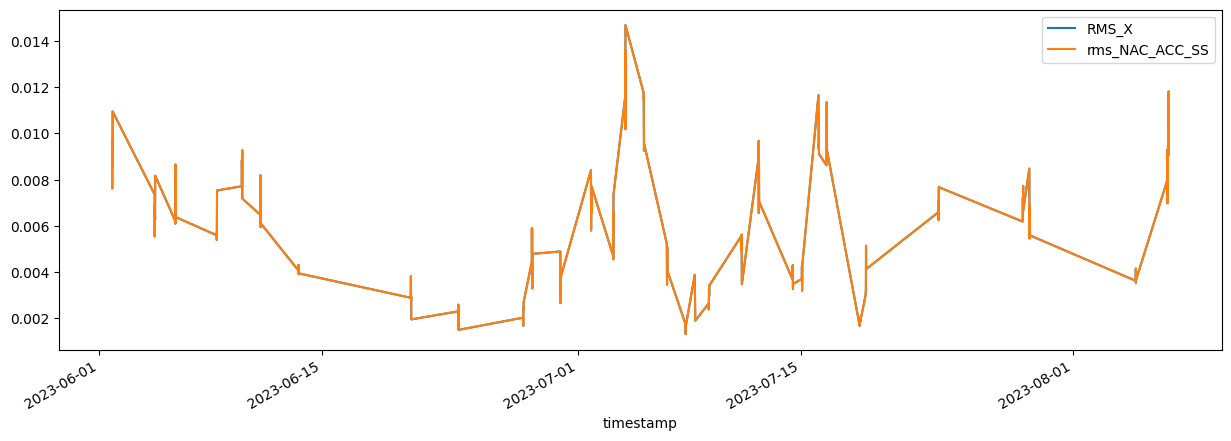

In [39]:


import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


In [40]:

from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics = get_statistic(db_path,['Welch_X', 'Welch_Y', 'Welch_Z', 'RollingAverage_X', 'RollingAverage_Y', 'RollingAverage_Z'],
              [np.max,np.min,np.std,np.mean], 'processed_data',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics)


                Statistics Table                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Column Name      ┃ Statistic ┃          Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Welch_X          │ max       │       6.603327 │
│ Welch_X          │ min       │     -17.611923 │
│ Welch_X          │ std       │     0.86432964 │
│ Welch_X          │ mean      │     -2.4800177 │
│ Welch_Y          │ max       │       7.549939 │
│ Welch_Y          │ min       │     -18.384657 │
│ Welch_Y          │ std       │     0.34529474 │
│ Welch_Y          │ mean      │     -2.4430842 │
│ Welch_Z          │ max       │      2.2734365 │
│ Welch_Z          │ min       │     -17.452734 │
│ Welch_Z          │ std       │     -4.0997796 │
│ Welch_Z          │ mean      │     -6.0021515 │
│ RollingAverage_X │ max       │     0.07200729 │
│ RollingAverage_X │ min       │    -0.06929287 │
│ RollingAverage_X │ std       │   0.0064177564 │
│ RollingAverage_X │ mean      │  2.8434362e-08 │
│ RollingAverage_Y │ max       │     0.08819653 │
│ RollingAverage_Y │ min       │    -0.08796526 │
│ RollingAverage_Y │ std       │    0.005357963 │
│ RollingAverage_Y │ mean      │ -2.6041715e-08 │
│ RollingAverage_Z │ max       │    0.010081319 │
│ RollingAverage_Z │ min       │   -0.009372458 │
│ RollingAverage_Z │ std       │  0.00059588684 │
│ RollingAverage_Z │ mean      │  1.0569516e-08 │
└──────────────────┴───────────┴────────────────┘

In [43]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,['DEM5_TP_SG_LAT014_Mtn','mean_windspeed'],
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)


                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
│ mean_windspeed        │ max       │      23.4941 │
│ mean_windspeed        │ min       │       0.4712 │
│ mean_windspeed        │ std       │       4.2531 │
│ mean_windspeed        │ mean      │       9.0622 │
└───────────────────────┴───────────┴──────────────┘

In [57]:
statistics_scada['DEM']= statistics_scada['DEM5_TP_SG_LAT014_Mtn']


In [58]:
from src.model.prepared_queries import simple_view, do_nothing
columns = ["Welch_X","RollingAverage_X"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform())]+1*[FromBuffer()]
freq_axis_masked = transform_func[0][1].freq_axis_masked
fleet_leaders = settings.norther.fleet_leader.to_list()
fleet_leaders_str = ', '.join([f"'{leader}'" for leader in fleet_leaders])

key_query  = f"""SELECT id FROM processed_data 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'AND turbine_name IN ({fleet_leaders_str})
"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing, 
    view_table_name='processed_data',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=64,
    cached=True,
    return_dict=True
)

data_loader.setup()
for b in data_loader.train_dataloader():
    print(b)
    break

{'Welch_X': tensor([[-3.5491, -4.4019, -4.2107,  ..., -3.8881, -3.3894, -3.8090],
        [-3.2002, -3.0231, -3.5604,  ..., -3.6836, -3.7222, -4.0819],
        [-4.2857, -5.2522, -6.9906,  ..., -6.0139, -6.0184, -5.8446],
        ...,
        [-4.1606, -4.7416, -6.1269,  ..., -2.9280, -2.7803, -3.2456],
        [-2.8723, -3.7411, -4.9689,  ..., -4.8014, -4.1082, -3.8887],
        [-2.4655, -2.9046, -3.1717,  ..., -1.9043, -2.0613, -2.2392]]), 'RollingAverage_X': tensor([[ 5.6926e-03,  3.6171e-03, -1.9046e-05,  ..., -2.1008e-03,
         -6.7820e-03, -6.4974e-03],
        [ 8.4188e-04, -2.2355e-03, -2.8502e-03,  ...,  1.1865e-03,
          5.3760e-03,  6.2988e-03],
        [-2.4290e-03,  9.1494e-04,  2.9325e-03,  ...,  8.6097e-04,
          8.4107e-04,  2.2900e-04],
        ...,
        [ 2.0713e-03,  5.3705e-05, -1.8600e-03,  ...,  3.1235e-04,
          9.1100e-04,  1.0337e-03],
        [ 4.8980e-03,  4.0172e-03,  1.2432e-03,  ...,  6.1126e-04,
         -1.3581e-03, -1.7794e-03],
     

torch.Size([1248])
torch.Size([263])


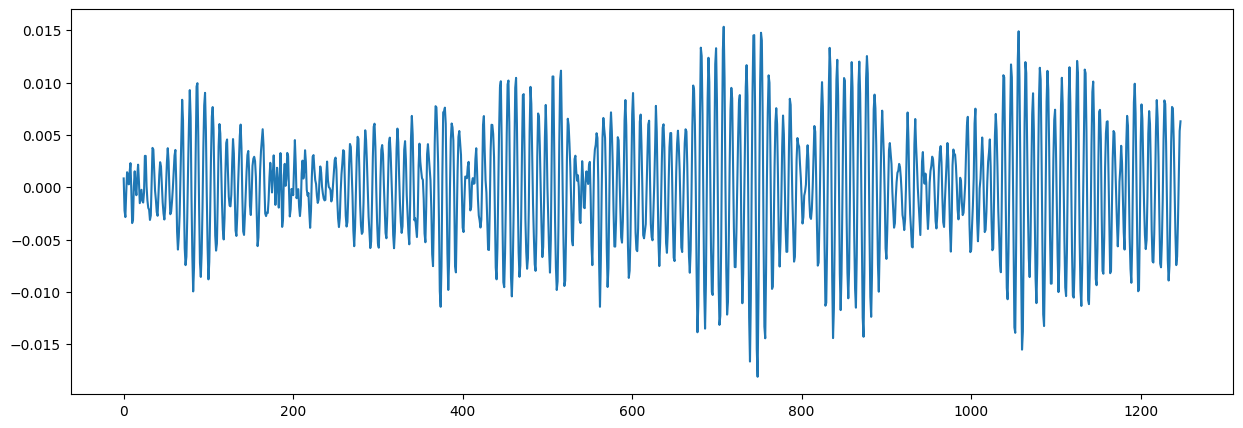

In [59]:
plt.figure(figsize=(15,5))
print(b['RollingAverage_X'][1].shape)
print(b['Welch_X'][1].shape)
plt.plot(b['RollingAverage_X'][1])

In [68]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from src.model.backbone.AE import TrainingSimpleAE
import torch
torch.set_float32_matmul_precision("high")
# Initialize the model
ae_model = TrainingSimpleAE(
    input_spec={'Welch_X': 263},
    latent_dim=3,
    hidden_dims=[1024,512,248,32],
    activation_str='leakyrelu',
    batch_norm= False,
    dropout=0,
    normalization_values=statistics,
    lr=5e-4,
)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="vae-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min"
)

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=150,
    accelerator='gpu',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
)

# Train the model
trainer.fit(ae_model, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | SimpleAutoEncoder | 1.9 M  | train
1 | loss_fn | MSELoss           | 0      | train
------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.444     Total estimated model params size (MB)
16        Modules in train mode
1         Modules in eval mode


Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [76]:
checkpoint_callback.best_model_path

'/home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/vae-epoch=80-val_loss=0.60.ckpt'

In [77]:

best_ae_path = Path(checkpoint_callback.best_model_path)
model_ae = TrainingSimpleAE.load_from_checkpoint(best_ae_path)


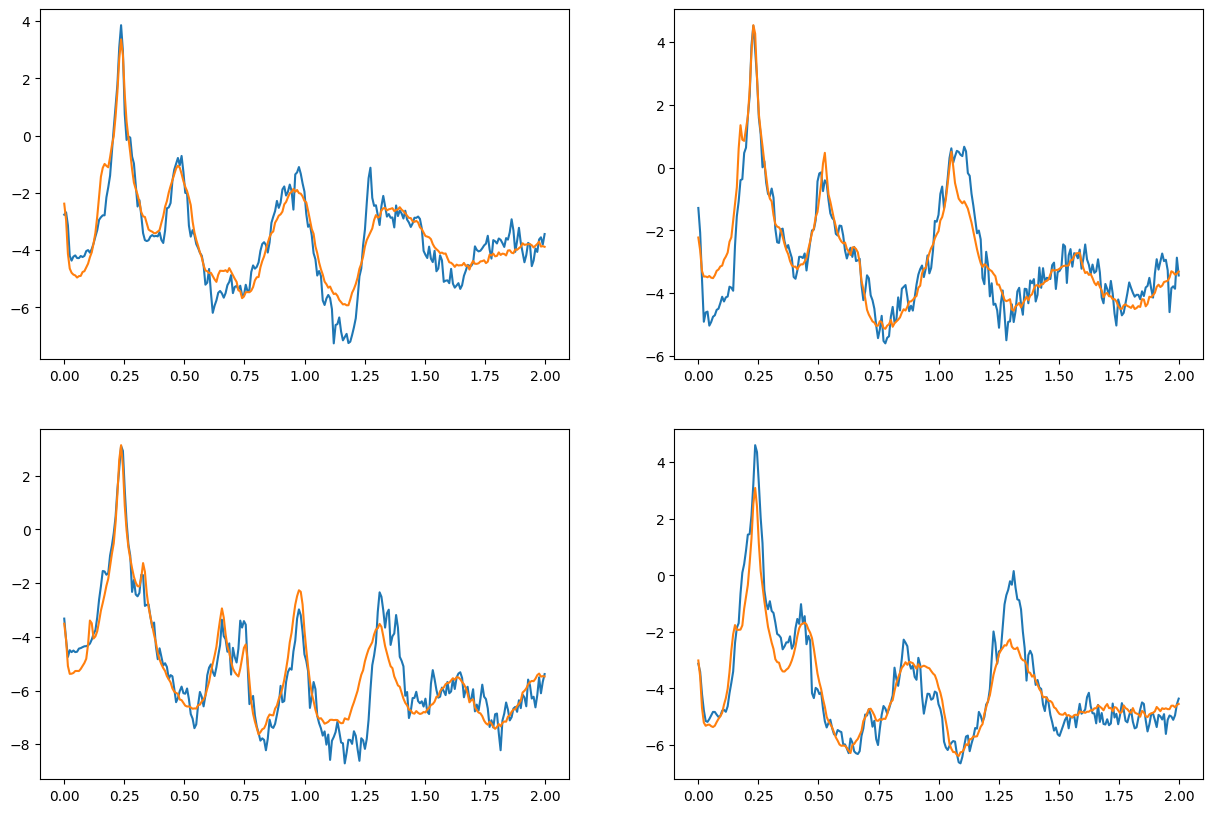

In [78]:
model_ae.to('cpu')
data = next(iter(data_loader.train_dataloader()))
data = next(iter(data_loader.train_dataloader()))
data_rec = model_ae(data) 
data=data['Welch_X']
data_rec = data_rec["Welch_X"]['reconstruction']
fig,ax  = plt.subplots(2,2,figsize=(15,10))
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot(freq_axis_masked, psd_in.cpu().numpy())
    ax[i//2, i%2].plot(freq_axis_masked, psd_out.cpu().detach().numpy())
plt.show()

In [79]:

from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ['Welch_X', 'RollingAverage_X','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 1*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform())]+1*[FromBuffer()]+4*[ToTensor()]+ 2*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem 
WHERE Turbine_name IN ('{"','".join(fleet_leaders[:5])}')
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096,
    cached=True,
    return_dict=True
)
data_loader_dem.setup() 

In [80]:
dfs = []
for b in data_loader_dem.all_dataloader():
    model_ae.eval()
    with torch.no_grad():
        enc = model_ae(b)
    mu = enc['Welch_X']['latent']
    df_temp = pd.DataFrame({'mean_windspeed':b['mean_windspeed'].cpu().numpy(),
                            'mean_power':b['mean_power'].cpu().numpy(),
                            'mean_pitch':b['mean_pitch'].cpu().numpy(),
                            'mean_rpm':b['mean_rpm'].cpu().numpy(),
                            'caseID':b['caseID'],
                            'embedding':[e.cpu().numpy() for e in mu],
                            'turbine_name':b['turbine_name']})
    dfs.append(df_temp)
df = pd.concat(dfs)

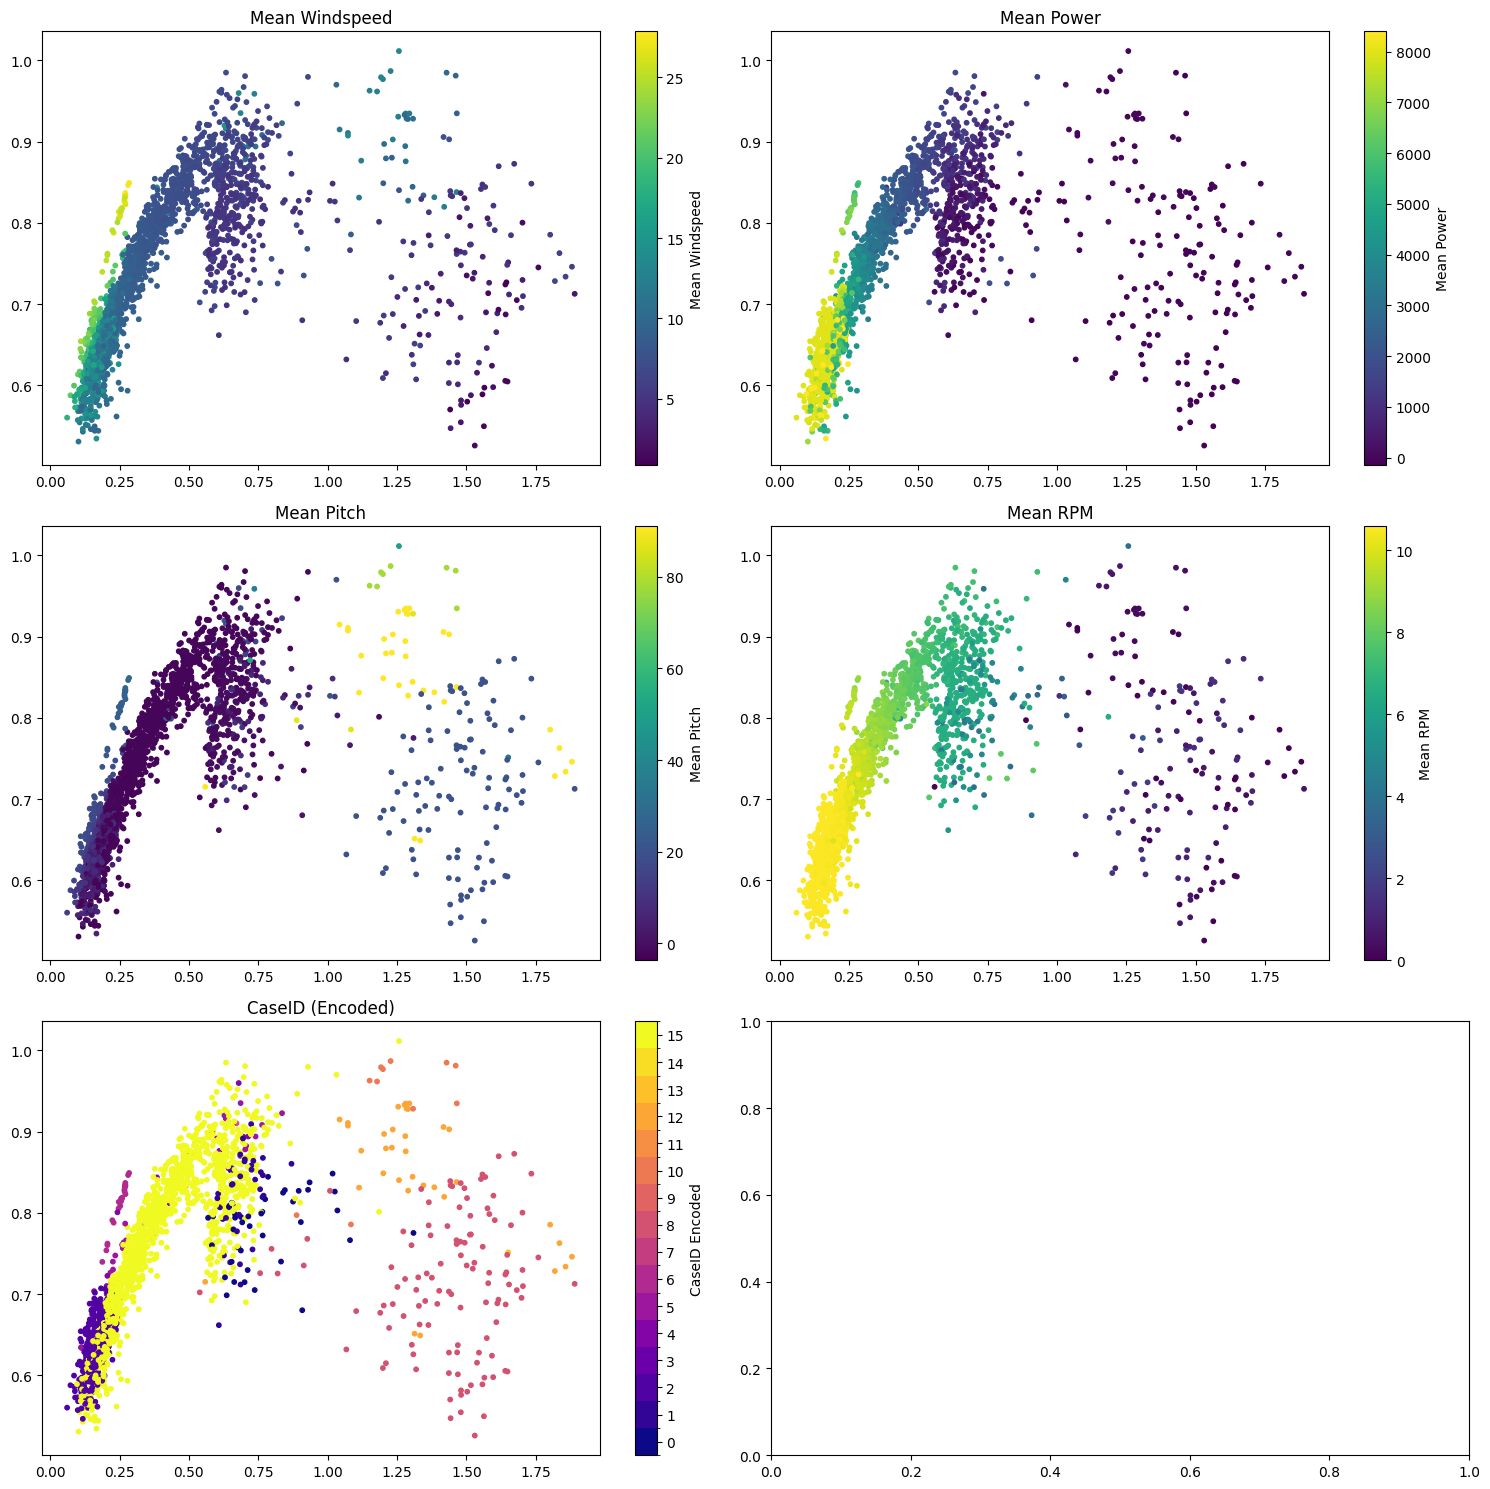

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [81]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


# Encode caseID as numeric labels
label_encoder = LabelEncoder()
df['caseID_encoded'] = label_encoder.fit_transform(df['caseID']) 

# Retrieve the mapping of encoded labels to original caseID labels
encoded_labels = df['caseID_encoded'].unique()
original_labels = label_encoder.inverse_transform(encoded_labels)
label_mapping = dict(zip(encoded_labels, original_labels))

# Combine all embeddings into a numpy array
df_turb = df.query('turbine_name == "NRTC01"')
embeddings = np.vstack(df_turb['embedding'].values)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)

embeddings_2d = embeddings
# Plot the t-SNE projection with color bars for each plot
# Plot the t-SNE projection with color bars for each plot
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Mean Windspeed
sc1 = ax[0, 0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_turb['mean_windspeed'], cmap='viridis', s=10)
ax[0, 0].set_title('Mean Windspeed')
fig.colorbar(sc1, ax=ax[0, 0], label='Mean Windspeed')

# Mean Power
sc2 = ax[0, 1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_turb['mean_power'], cmap='viridis', s=10)
ax[0, 1].set_title('Mean Power')
fig.colorbar(sc2, ax=ax[0, 1], label='Mean Power')

# Mean Pitch
sc3 = ax[1, 0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_turb['mean_pitch'], cmap='viridis', s=10)
ax[1, 0].set_title('Mean Pitch')
fig.colorbar(sc3, ax=ax[1, 0], label='Mean Pitch')

# Mean RPM
sc4 = ax[1, 1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_turb['mean_rpm'], cmap='viridis', s=10)
ax[1, 1].set_title('Mean RPM')
fig.colorbar(sc4, ax=ax[1, 1], label='Mean RPM')

# CaseID Encoded (Discrete Colorbar)
cmap = plt.get_cmap('plasma', len(df_turb['caseID_encoded'].unique()))
norm = BoundaryNorm(np.arange(-0.5, len(df_turb['caseID_encoded'].unique())), cmap.N)
sc5 = ax[2, 0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_turb['caseID_encoded'], cmap=cmap, norm=norm, s=10)
ax[2, 0].set_title('CaseID (Encoded)')
cbar = fig.colorbar(sc5, ax=ax[2, 0], label='CaseID Encoded', ticks=np.arange(0, len(df_turb['caseID_encoded'].unique())))


# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
ax[2, 1].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

